In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn

## Pytorch

![](https://github.com/pytorch/pytorch/raw/master/docs/source/_static/img/pytorch-logo-dark.png)

In [2]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

In [3]:
import torch
from torch.utils.data import DataLoader

class DLoader(DataLoader):
    def __init__ (self, dataset, batch_size=64, max_batch_size=1024, shuffle=False, **kwargs):
        super().__init__(dataset, batch_size=batch_size, shuffle=shuffle, **kwargs)
        self.start_iter = iter(self)
        self.current = 0
        self.batch_hist = []

        self.defaults = {
            "A": 0.0,
            "B": 0.0,
            "MaxB": max_batch_size,
            "k": 0,
            "b0": batch_size,
            "prev_len": 0,
            "next_len": batch_size,
            "len": batch_size,
            "beta": 0,
            "x": torch.Tensor([]),
            "grad": torch.Tensor([]),
            "prev_x": torch.Tensor([]),
            "prev_grad": torch.Tensor([]),
            "prev_beta": 0,
        }

    def step(self, params):
        x = torch.Tensor([])
        grad = torch.Tensor([])
        flag = True
        for p in params:
            if flag:
                flag = False
                x = torch.flatten(p.data)
                grad = torch.flatten(p.grad.data)
            else:
                x = torch.cat([x, torch.flatten(p.data)])

                grad = torch.cat([grad, torch.flatten(p.grad.data)])

        k = self.defaults["k"]
        if k == 0:
            self.defaults["grad"] = grad
            self.defaults["x"] = x
            self.defaults['k'] += 1
            self.defaults["next_len"] = min(self.defaults["len"] * 2, self.defaults["MaxB"])
            return

        self.defaults["prev_grad"] = self.defaults["grad"]
        self.defaults["prev_x"] = self.defaults["x"]
        self.defaults["grad"] = grad
        self.defaults["x"] = x
        beta = torch.dot(
            self.defaults["grad"] - self.defaults["prev_grad"],
            self.defaults["x"] - self.defaults["prev_x"]
        )
        self.defaults["len_prev"] = self.defaults["len"]
        self.defaults["len"] = self.defaults["next_len"]
        self.defaults["next_len"] = min(self.defaults["len"] * 2, self.defaults["MaxB"])
        self.defaults['beta'] = beta

        if k > 1:
            beta_prev = self.defaults["beta"]
            len_prev = self.defaults["len_prev"]
            len_curr = self.defaults["len"]

            if len_prev != len_curr:
                B = (beta_prev - beta) / (len_prev - len_curr)
                A = len_curr - beta * B
                self.defaults["A"] = A
                self.defaults["B"] = B

                next_len = max(1, min(self.defaults["MaxB"], self.defaults["B"] / (beta - A)))
                self.defaults["next_len"] = next_len

        self.defaults['k'] += 1

    def __iter__(self):
        self.start_iter = iter(super().__iter__())
        self.current = 0
        return self

    def __next__(self):
        if self.current < len(self):
            self.current += 1


            n = max(1, self.defaults["next_len"] // self.defaults["b0"])
            n = min(n, self.defaults["MaxB"] // self.defaults["b0"])
            self.batch_hist.append(self.defaults["b0"] * n)
            batches = []
            try:
                for _ in range(n):
                    batches.append(next(self.start_iter))
            except StopIteration:
                pass

            if len(batches) == 0:
                raise StopIteration

            first_batch = batches[0]
            for additional_batch in batches[1:]:
                for i, data in enumerate(additional_batch):
                    first_batch[i] = torch.cat([first_batch[i], data])

            return first_batch
        else:
            self.current = 0
            raise StopIteration

In [4]:
#Давайте сгенерируем датасет и посмотрим на него!
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

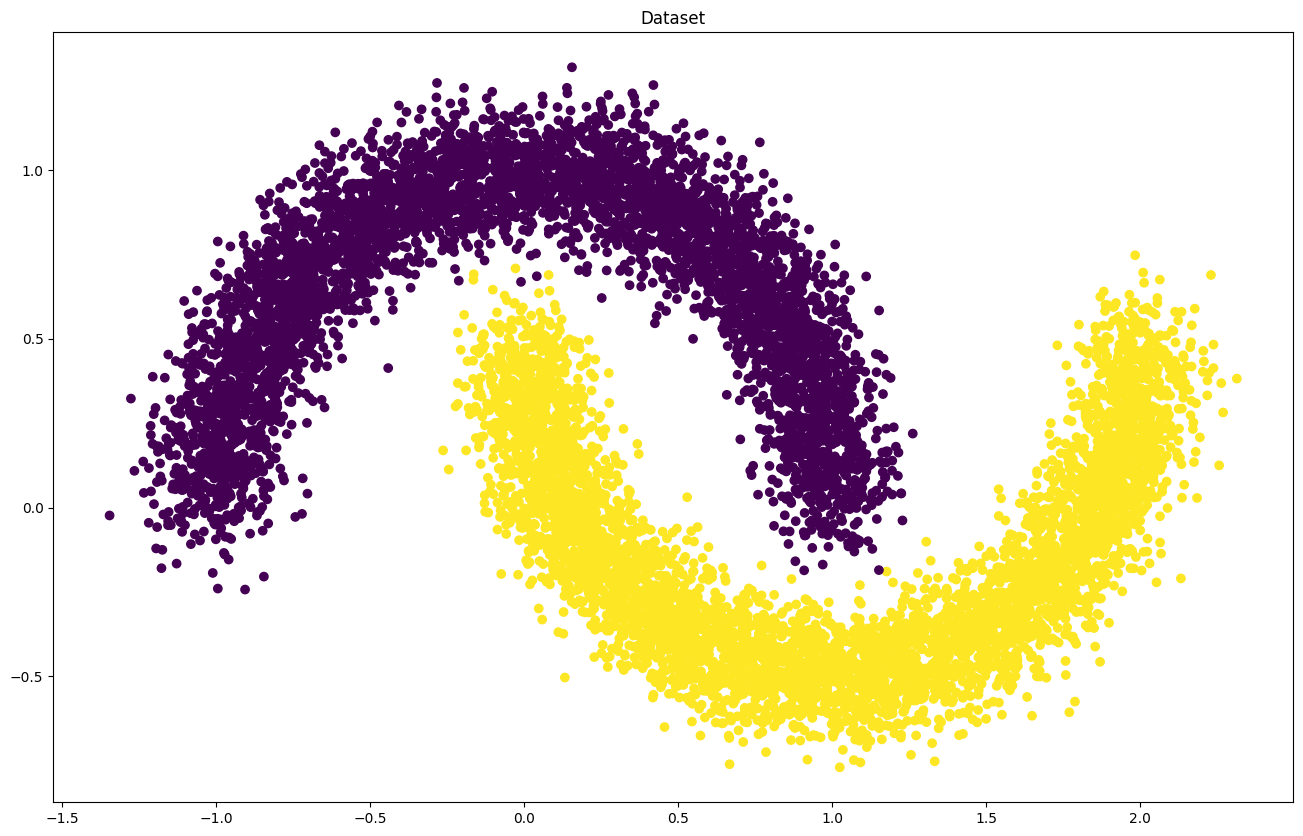

In [5]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

In [6]:
#сделаем разделение на train и test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
#Задание. Создайте тензоры с обучающими и тестовыми данными
X_train_t =  torch.Tensor(X_train)
y_train_t =  torch.Tensor(y_train)
X_val_t =  torch.Tensor(X_val)
y_val_t =  torch.Tensor(y_val)

In [10]:
class LogisticRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))


    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [19]:
#Создаем Dataset и DataLoader.
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

In [94]:

b0 = 64

In [86]:
def train(model,optimizer,loss_function,losses):
  tol = 1e-3
  max_epochs = 30
  stop_it = False
  loss_function = nn.BCEWithLogitsLoss()
  for epoch in range(max_epochs):
      for X_batch, y_batch in train_dataloader:
          optimizer.zero_grad()
          outp =  logistic_regression(X_batch)

          loss = loss_function(outp, y_batch.unsqueeze(1).float()) #посчитать лосс от outp и y_batch.unsqueeze(1).float()
          for i in range(len(X_batch) // b0):
            losses.append(loss.item())
          loss.backward()
          optimizer.step()
          probabilities = torch.sigmoid(outp) #примените сигмоиду к outp
          preds = (probabilities > 0.5).type(torch.long)
          batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

In [103]:
losses_sgd_with_optm = []
torch.manual_seed(42)
train_dataloader = DLoader(train_dataset, batch_size=64,max_batch_size=1024)
val_dataloader = DataLoader(val_dataset, batch_size=64)
logistic_regression = LogisticRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(logistic_regression.parameters(), lr=16e-3)
train(logistic_regression,optimizer,loss_function,losses_sgd_with_optm)

In [101]:

torch.manual_seed(42)
losses_sgd = []
train_dataloader = DataLoader(train_dataset, batch_size=1024)
val_dataloader = DataLoader(val_dataset, batch_size=64)
logistic_regression = LogisticRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(logistic_regression.parameters(), lr=15e-3)
train(logistic_regression,optimizer,loss_function,losses_sgd)

In [106]:

torch.manual_seed(42)
losses_adam_with_optm = []
train_dataloader = DLoader(train_dataset, batch_size=64,max_batch_size=1024)
val_dataloader = DataLoader(val_dataset, batch_size=64)
logistic_regression = LogisticRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(logistic_regression.parameters(), lr=1e-3)
train(logistic_regression,optimizer,loss_function,losses_adam_with_optm)

In [107]:

torch.manual_seed(42)
losses_sadam = []
train_dataloader = DataLoader(train_dataset, batch_size=1024)
val_dataloader = DataLoader(val_dataset, batch_size=64)
logistic_regression = LogisticRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(logistic_regression.parameters(), lr=3e-3)
train(logistic_regression,optimizer,loss_function,losses_sadam)

In [91]:
import scipy

In [92]:
len(losses_adam_with_optm)

3750

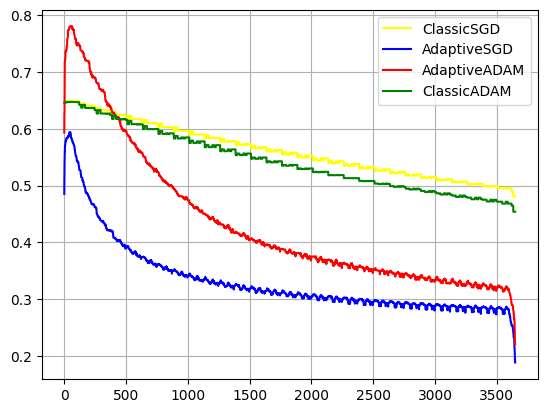

In [108]:

plt.plot(range(len(losses_sgd[100:])),scipy.signal.medfilt(losses_sgd[100:], 101), label = "ClassicSGD",color = 'yellow')
plt.plot(range(len(losses_sgd_with_optm[100:])),scipy.signal.medfilt(losses_sgd_with_optm[100:], 101), label = "AdaptiveSGD",color = 'blue')
plt.legend()
#plt.savefig('SGD_Graphics.png')
#plt.clf()
plt.plot(range(len(losses_adam_with_optm[100:])),scipy.signal.medfilt(losses_adam_with_optm[100:], 101), label = "AdaptiveADAM", color = 'red')
plt.plot(range(len(losses_sgd[100:])),scipy.signal.medfilt(losses_sadam[100:], 101), label = "ClassicADAM", color = 'green')
plt.legend()
plt.grid()
#plt.savefig('ADAM_Graphics.png')
plt.show()

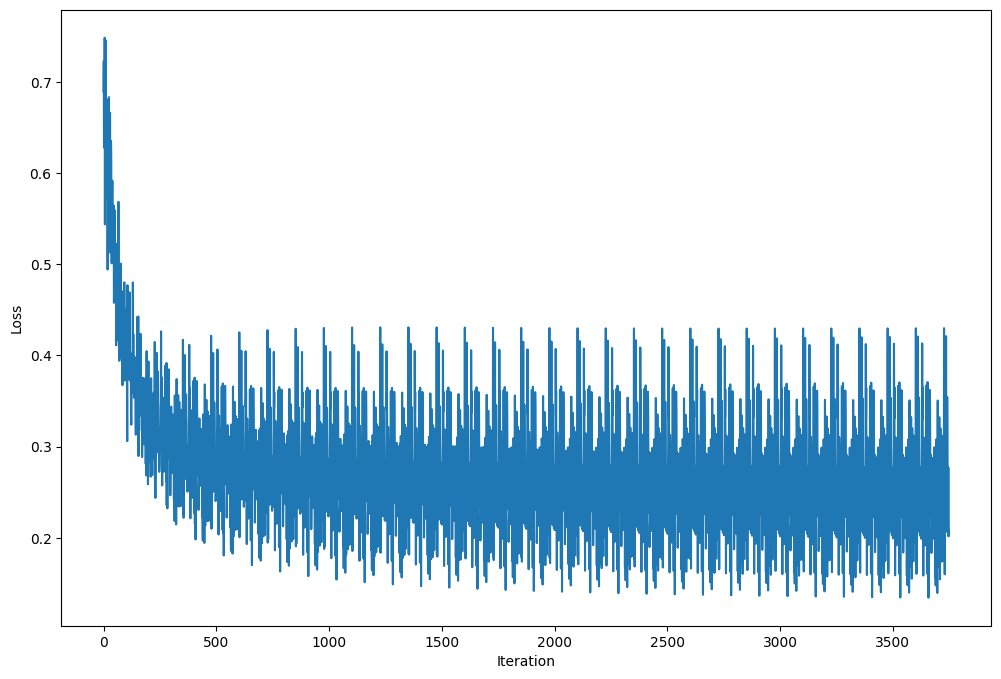

In [53]:
#Визуализируем
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses_sgd_with_optm)), losses_sgd_with_optm)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

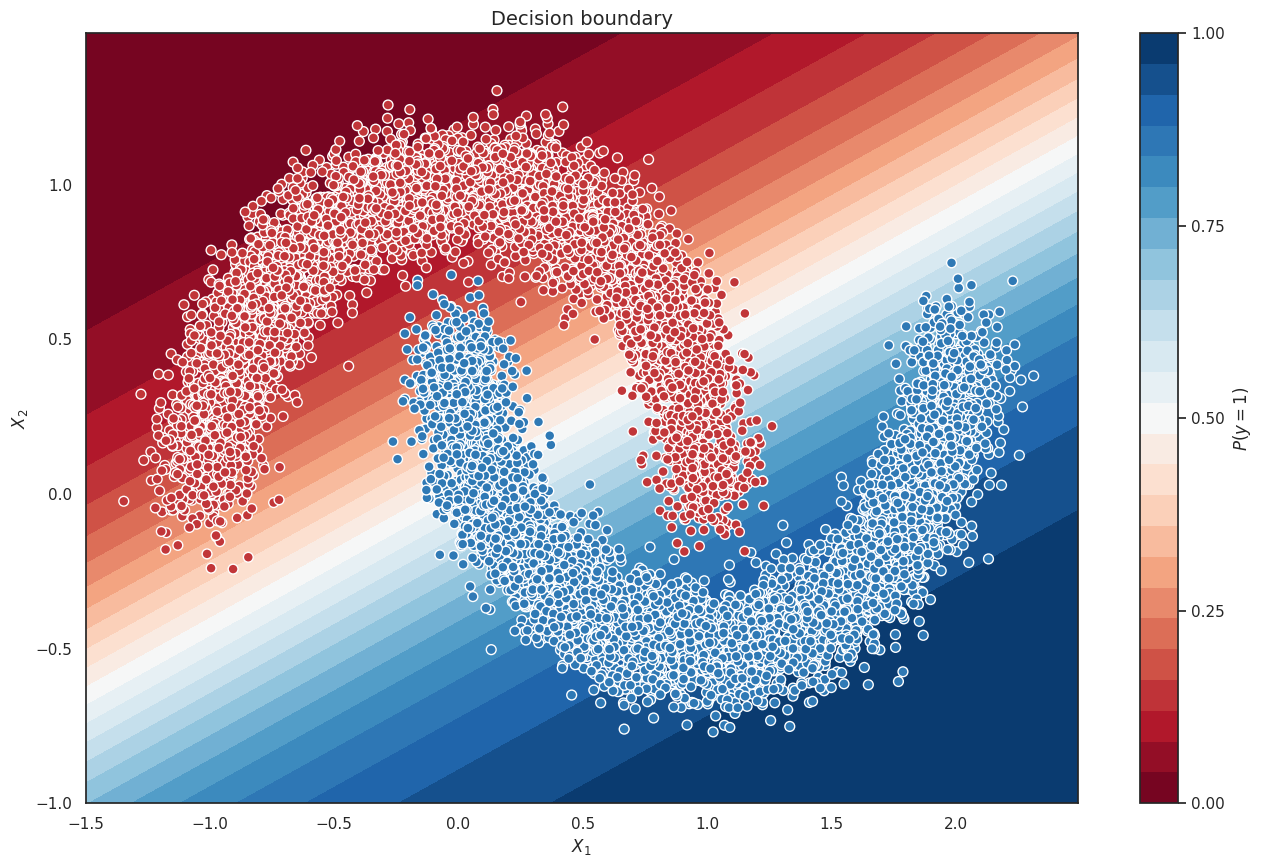

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(logistic_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание.  Посчитайте accuracy на test.

In [ ]:
from sklearn.metrics import accuracy_score

#ваш код здесь